In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, roc_auc_score, plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from model import *
import pickle

The model library was taken from Flatiron's Workflow with pipelines lecture.

In [2]:
df = pd.read_csv('./data/training_set_features.csv')
df2 = pd.read_csv('./data/training_set_labels.csv')

A test set_feature was provided as well but unfortunately the set_labels that contain the target is with-held for the DataDriven competition. As such for the purposes of model testing, a train-test split will be performed on the training data provided. 

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [5]:
df2

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
df.education.value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [8]:
df.employment_status.value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

This makes sense as to why there would be so many missing values for the columns `employment_industry` and `employment_occupation`.

In [9]:
df.health_insurance.value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

In [10]:
df.race.value_counts()
#Do not want to introduce racial bias into this so we'll be dropping this

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

In [11]:
df.child_under_6_months.value_counts()

0.0    23749
1.0     2138
Name: child_under_6_months, dtype: int64

In [12]:
df.hhs_geo_region.value_counts()

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

**Data is from a 2009 H1N1 Flu survey** 

In [13]:
df.isna().sum().sum()
#too many nulls in general to drop all of them

60762

In [14]:
df2.isna().sum().sum()

0

## Data Cleaning before Train-test split

In [15]:
df3 = pd.concat([df,df2], axis = 1)

In [16]:
df3

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,26702,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,26703,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,26704,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,26705,0,0


In [17]:
df3.employment_status.value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [18]:
df3.employment_status.isna().sum()

1463

In [19]:
10231 + 1453

11684

In [20]:
df3.employment_industry.isna().sum()

13330

In [21]:
13330 - 11684 #how much nulls should remain

1646

In [22]:
#replacement of some nan bases of whether they were employed or not as it makes sense that they would not have an industy
#or occupation
df3.loc[df3['employment_status'] == "Not in Labor Force", 'employment_industry'] = "not_applicable"
df3.loc[df3['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "not_applicable"

In [23]:
df3.employment_industry.isna().sum()

3099

In [24]:
df3.loc[df3['employment_status'] == "Unemployed", 'employment_industry'] = "not_applicable"
df3.loc[df3['employment_status'] == "Unemployed", 'employment_occupation'] = "not_applicable"

In [25]:
df3.employment_industry.isna().sum()

1646

In [26]:
df3.employment_occupation.value_counts()

not_applicable    11684
xtkaffoo           1778
mxkfnird           1509
emcorrxb           1270
cmhcxjea           1247
xgwztkwe           1082
hfxkjkmi            766
qxajmpny            548
xqwwgdyp            485
kldqjyjy            469
uqqtjvyb            452
tfqavkke            388
ukymxvdu            372
vlluhbov            354
oijqvulv            344
ccgxvspp            341
bxpfxfdn            331
haliazsg            296
rcertsgn            276
xzmlyyjv            248
dlvbwzss            227
hodpvpew            208
dcjcmpih            148
pvmttkik             98
Name: employment_occupation, dtype: int64

In [27]:
df3.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,respondent_id,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,13353.000000,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,6676.500000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,13353.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,20029.500000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,26706.000000,1.000000,1.000000


We see that there is of binary or multilabel numericals

In [28]:
df3.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [29]:
df3.seasonal_vaccine.value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

In [30]:
X = df3.drop(['respondent_id','race', 'h1n1_vaccine', 'seasonal_vaccine'],
            axis = 1)
y = df3['h1n1_vaccine']

###  Train-test-split 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [32]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
15654,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,2.0,4.0,4.0,4.0,65+ Years,< 12 Years,Male,Below Poverty,Married,Own,Not in Labor Force,kbazzjca,Non-MSA,1.0,0.0,not_applicable,not_applicable
14559,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,45 - 54 Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,kbazzjca,"MSA, Principle City",0.0,0.0,pxcmvdjn,xqwwgdyp
13752,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0,65+ Years,Some College,Male,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,Non-MSA,1.0,0.0,not_applicable,not_applicable
21985,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,1.0,65+ Years,< 12 Years,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,0.0,not_applicable,not_applicable
18196,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,65+ Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Not in Labor Force,fpwskwrf,Non-MSA,1.0,0.0,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,18 - 34 Years,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,3.0,not_applicable,not_applicable
17289,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,2.0,2.0,35 - 44 Years,College Graduate,Female,"<= $75,000, Above Poverty",NaN,Own,Employed,dqpwygqj,"MSA, Not Principle City",0.0,1.0,pxcmvdjn,xgwztkwe
5192,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,4.0,5.0,4.0,4.0,65+ Years,College Graduate,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
12172,3.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,4.0,1.0,5.0,4.0,1.0,55 - 64 Years,Some College,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,Non-MSA,0.0,0.0,atmlpfrs,xqwwgdyp


In [33]:
train_df = pd.concat([X_train,y_train], axis =1)

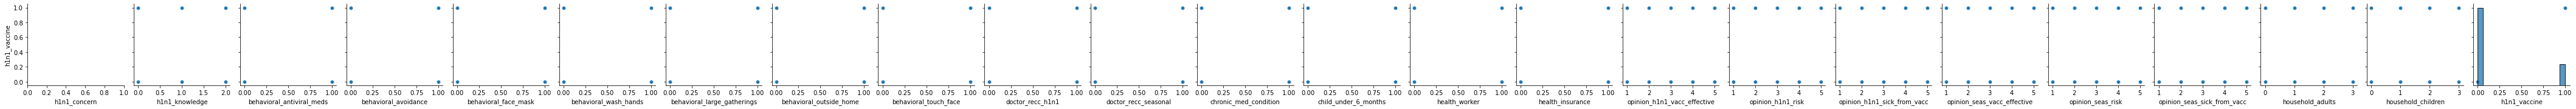

In [34]:
sns.pairplot(train_df, y_vars= 'h1n1_vaccine') #graph makes sense looking at the dictionary for the columns

#### Dummy Regressor for train and test

In [35]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)

In [36]:
dummy_results = ModelWithCV(dummy, 'dummy', X_train, y_train)

In [37]:
#The sns ain't working from the model.py even after importing LOL
# fig, ax = plt.subplots()

# ax = dummy_results.plot_cv(ax)
# plt.tight_layout();

78.8% accurate.

CV Results for `dummy` model:
            0.78732 ± 0.00000 accuracy
        


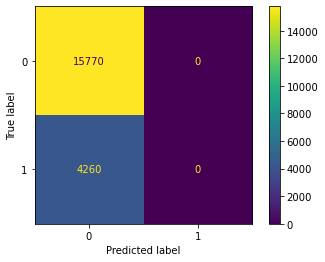

In [38]:
plot_confusion_matrix(dummy, X_train, y_train);
dummy_results.print_cv_summary()

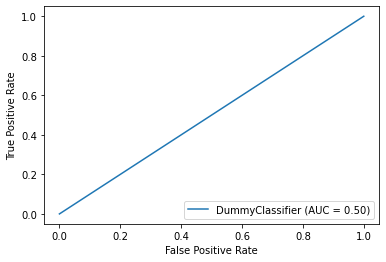

In [39]:
plot_roc_curve(dummy, X_train, y_train)

In [40]:
preds = dummy.predict(X_train)

f1_score(y_train, preds)

0.0

#### simple models

Using all our numerical columns as our baseline without ohr or scaling.

In [41]:
X_simple = X_train.select_dtypes(np.number)
y_simple = y_train

In [42]:
#try without
#X_sm, y_sm = SMOTE(sampling_strategy= 0.35, random_state=1).fit_resample(X_simple, y_simple)

In [43]:
#do i need to do kfolds here or does a pipeline work?

In [44]:
X_simple_pipe = Pipeline(steps=[('simple_impute', SimpleImputer(strategy='most_frequent')),
                                ('lr', LogisticRegression(random_state=1))]).fit(X_simple,y_simple)

In [45]:
#X_simple_trans = pd.DataFrame(SimpleImputer().fit_transform(X_simple), columns = X_simple.columns)

In [46]:
#X_simple_trans

In [47]:
#logreg1 = LogisticRegression(random_state=1).fit(X_simple_trans,y_simple)

In [48]:
#logreg1.score(X_simple_trans,y_simple)

In [49]:
simple_log = ModelWithCV(X_simple_pipe, 'logreg', X_simple, y_simple, cv_now = True)

In [50]:
log_score = simple_log.cv_mean

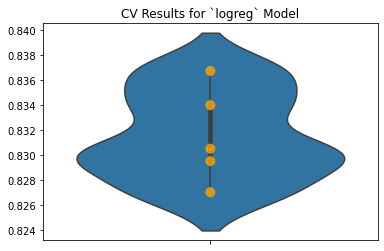

In [51]:
fig, ax = plt.subplots()

ax = simple_log.plot_cv(ax)

CV Results for `logreg` model:
            0.83155 ± 0.00343 accuracy
        


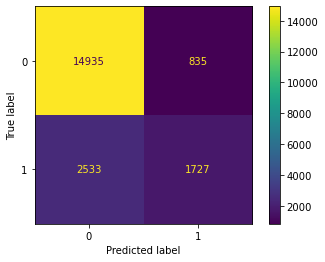

In [52]:
plot_confusion_matrix(X_simple_pipe, X_simple, y_simple);
simple_log.print_cv_summary()

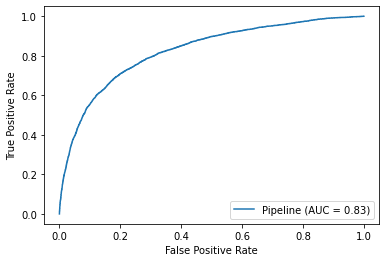

In [53]:
plot_roc_curve(X_simple_pipe, X_simple, y_simple)

In [54]:
preds = X_simple_pipe.predict(X_simple)

f1_score(y_simple, preds)

0.5063031369099971

#### simple svc

In [55]:
#sv1 = SVC(random_state=1).fit(X_simple_trans,y_simple)

In [56]:
#sv1_score = ModelWithCV(sv1, 'sv1', X_simple_trans, y_simple, cv_now = True).cv_mean

In [57]:
svc2_pipe = Pipeline(steps=[('simple_impute', SimpleImputer(strategy='most_frequent')),
                                ('lr', SVC(random_state=1, kernel='linear'))]).fit(X_simple,y_simple)

In [58]:
#svc2 = SVC(random_state=1, kernel='linear').fit(X_simple_trans,y_simple)

In [59]:
sv2_results = ModelWithCV(svc2_pipe, 'svc2', X_simple, y_simple, cv_now = True)

In [60]:
sv2_score = sv2_results.cv_mean

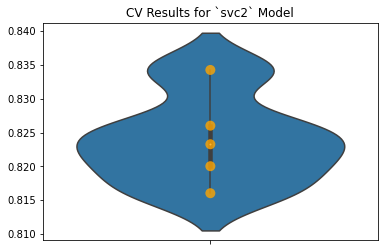

In [61]:
fig, ax = plt.subplots()

ax = sv2_results.plot_cv(ax)

CV Results for `svc2` model:
            0.82391 ± 0.00615 accuracy
        


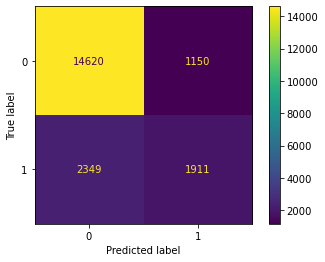

In [62]:
plot_confusion_matrix(svc2_pipe, X_simple, y_simple);
sv2_results.print_cv_summary()

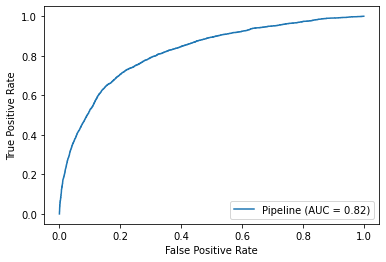

In [63]:
plot_roc_curve(svc2_pipe, X_simple, y_simple)

In [64]:
preds = svc2_pipe.predict(X_simple)

f1_score(y_simple, preds)

0.5220598278923644

In [65]:
#svc2.coef_
#gives back values of the features but only works with linear

#### simple KNN 

In [66]:
knn_p = Pipeline(steps=[('simple_impute', SimpleImputer(strategy='most_frequent')),
                                ('knn', KNeighborsClassifier())]).fit(X_simple,y_simple)

In [67]:
#knn = KNeighborsClassifier().fit(X_simple_trans, y_simple)

In [68]:
knn_result = ModelWithCV(knn_p, 'knn', X_simple, y_simple, cv_now = True)

In [69]:
knn_score = knn_result.cv_mean

CV Results for `knn` model:
            0.81188 ± 0.00314 accuracy
        


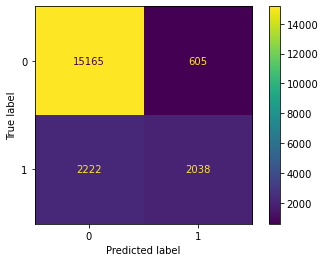

In [70]:
plot_confusion_matrix(knn_p, X_simple, y_simple);
knn_result.print_cv_summary()

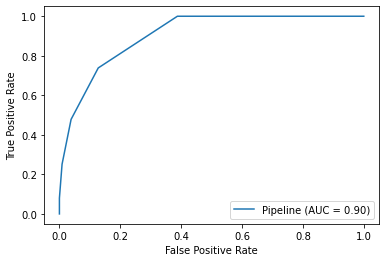

In [71]:
plot_roc_curve(knn_p, X_simple, y_simple)

In [72]:
preds = knn_p.predict(X_simple)

f1_score(y_simple, preds)

0.5904679125018109

#### simple dtree

In [73]:
dtree_pipe = Pipeline(steps=[('simple_impute', SimpleImputer(strategy='most_frequent')),
                                ('knn', DecisionTreeClassifier(random_state=1))]).fit(X_simple,y_simple)

In [74]:
#dtree = DecisionTreeClassifier(random_state=1).fit(X_simple_trans,y_simple)

In [75]:
dtree_result = ModelWithCV(dtree_pipe, 'dt', X_simple, y_simple, cv_now = True)

In [76]:
dtree_score = dtree_result.cv_mean

CV Results for `dt` model:
            0.74383 ± 0.00431 accuracy
        


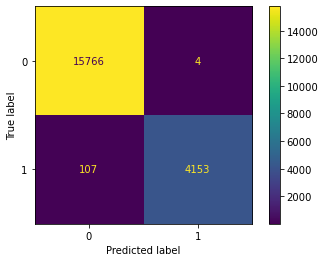

In [77]:
plot_confusion_matrix(dtree_pipe, X_simple, y_simple);
dtree_result.print_cv_summary()

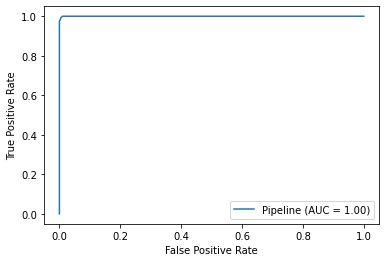

In [78]:
plot_roc_curve(dtree_pipe, X_simple, y_simple)

In [79]:
preds = dtree_pipe.predict(X_simple)

f1_score(y_simple, preds)

0.9868124034691695

In [80]:
dtree_pipe.feature_importances_

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

feature 14 , 15, and 19 seems to be the 'most' important in this simple that has not been scaled, followed closely by 0 16, 17,20,21. For this decision tree

In [81]:
print(f' logistic regression is {log_score},\n SVM score is {sv2_score}, \n knn is {knn_score},\n dtree is {dtree_score}')

 logistic regression is 0.8315526709935097,
 SVM score is 0.8239141288067898, 
 knn is 0.8118821767348976,
 dtree is 0.7438342486270594


Overall, all but one of our models performed better compared to our dummy model. The decision tree performed worse compared to our dummy of 77% while out logistic regression and support vector machine models performed the best, both at 83%.

##### let's put multiple default models in voting!

In [82]:
voting = VotingClassifier(estimators= [
    ('lr', X_simple_pipe),
    ('sv1', svc2_pipe),
    ('knn', knn_p),
    ('dt', dtree_pipe)
]
).fit(X_simple,y_simple)

In [83]:
voting_result = ModelWithCV(voting, 'voting', X_simple, y_simple, cv_now = True)

In [84]:
voting_score = voting_result.cv_mean

CV Results for `voting` model:
            0.82726 ± 0.00305 accuracy
        


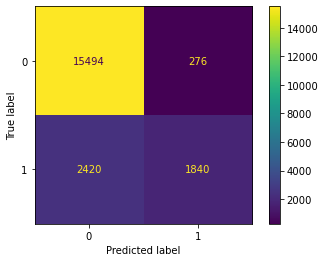

In [85]:
plot_confusion_matrix(voting, X_simple, y_simple);
voting_result.print_cv_summary()

In [86]:
preds = voting.predict(X_simple)

f1_score(y_simple, preds)

0.5771643663739021

### setting up pipelines for ohe/scaling and ct for further modeling

In [87]:
y_train.value_counts(normalize = True)

0    0.787319
1    0.212681
Name: h1n1_vaccine, dtype: float64

Slight Class imbalance where we can SMOTE if we want to. We will SMOTE to .35 to ensure that our data is closer to even split in terms of our target classes.

In [88]:
X_train.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,19961.000000,19946.000000,19979.000000,19861.000000,20017.000000,20001.000000,19963.000000,19966.000000,19936.000000,18413.000000,18413.000000,19287.000000,19404.000000,19417.000000,10832.000000,19725.000000,19726.000000,19722.000000,19668.000000,19628.000000,19607.000000,19844.000000,19844.000000
mean,1.616853,1.258047,0.046749,0.725895,0.068792,0.826759,0.360818,0.335020,0.675110,0.222234,0.331722,0.284751,0.083024,0.110779,0.882662,3.859316,2.344875,2.352145,4.025168,2.725494,2.114245,0.885457,0.534368
std,0.906326,0.618298,0.211106,0.446073,0.253106,0.378465,0.480250,0.472009,0.468345,0.415759,0.470845,0.451308,0.275926,0.313867,0.321837,1.001282,1.280582,1.358907,1.088557,1.382753,1.329751,0.751442,0.926018
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


we will use all our features this time around and scale/transofrm it out to see if it does any better in predicting.

In [89]:
cat_cols =['behavioral_antiviral_meds', 'behavioral_avoidance',
           'behavioral_face_mask','behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home',
           'behavioral_touch_face', 'doctor_recc_h1n1',
           'doctor_recc_seasonal', 'chronic_med_condition',
           'child_under_6_months', 'health_worker',
           'health_insurance', 'sex', 'income_poverty',
           'marital_status', 'rent_or_own', 'employment_status',
           'hhs_geo_region', 'census_msa', 'household_adults',
           'household_children', 'employment_industry', 'employment_occupation', 'age_group', 'education']

numeric = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
                  'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
                  'opinion_seas_vacc_effective', 'opinion_seas_risk',
                  'opinion_seas_sick_from_vacc']

cat_pipe = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
scale_pipe = Pipeline(steps=[('scale_impute', SimpleImputer(strategy='most_frequent')),
                              ('scale', StandardScaler())])

In [90]:
ct = ColumnTransformer(transformers=[
    ('cat', cat_pipe, X_train[cat_cols].columns),
    ('scale', scale_pipe, X_train[numeric].columns)
])

###### grid search logistic regression

In [91]:
#no grid search performed
logreg_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('logreg', LogisticRegression(random_state=1))
]).fit(X_train,y_train)

C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


When including all our features the acurracy increases from 78-79% to about 83%.

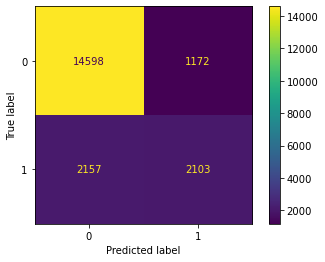

In [92]:
plot_confusion_matrix(logreg_pipe, X_train, y_train)

In [93]:
# log_params = {
#     'logreg__penalty' : ['l2', 'l1', 'none'],
#     'logreg__C' : [1,10,100],
#     'logreg__max_iter': [100,500,10000],
#     'logreg__solver': ['liblinear', 'saga', 'lbfgs','sag']
# }

In [94]:
# log_grid = GridSearchCV(estimator=logreg_pipe, param_grid=log_params, n_jobs=-1).fit(X_train,y_train)

In [95]:
#opening the saved log_grid from pickle
log_grid = pickle.load(open('log_grid_search.sav', 'rb'))

In [96]:
log_grid.best_params_

{'logreg__C': 1,
 'logreg__max_iter': 100,
 'logreg__penalty': 'l1',
 'logreg__solver': 'saga'}

In [97]:
log_grid.best_score_

0.8325511732401397

The best max_iter is a 100 which is our minimun set in the first params, so we adjust the max_iter to be between just 100 - 500.

In [98]:
# log_grid_pickle = 'log_grid_search.sav'
# pickle.dump(log_grid, open(log_grid_pickle, 'wb'))

In [99]:
# log_params_adj = {
#     'logreg__penalty' : ['l2', 'l1', 'none'],
#     'logreg__C' : [1,10,100],
#     'logreg__max_iter': [50,100,150,200],
#     'logreg__solver': ['liblinear', 'saga', 'lbfgs','sag']
# }

In [100]:
# log_grid1 = GridSearchCV(estimator=logreg_pipe, param_grid=log_params_adj, n_jobs=-1).fit(X_train,y_train)

In [101]:
# log_grid1_pickle = 'log_grid1_search.sav'
# pickle.dump(log_grid1, open(log_grid1_pickle, 'wb'))

In [102]:
log_grid1 = pickle.load(open('log_grid1_search.sav', 'rb'))

In [103]:
log_grid1.best_score_

0.8325511732401397

In [104]:
log_grid1.best_params_ #similar parameters except that the max_iter is 50 instead of 100 but score is the same so we'll keep as is

{'logreg__C': 1,
 'logreg__max_iter': 50,
 'logreg__penalty': 'l1',
 'logreg__solver': 'saga'}

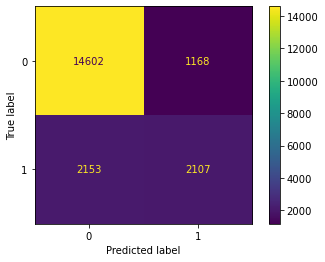

In [105]:
plot_confusion_matrix(log_grid, X_train, y_train)

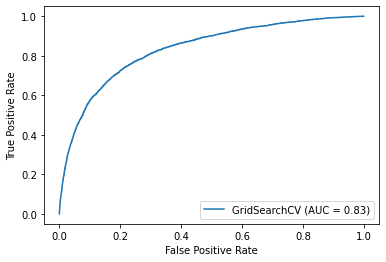

In [106]:
plot_roc_curve(log_grid, X_train, y_train)

In [107]:
preds = log_grid.predict(X_train)

f1_score(y_train, preds)

0.5592568015925681

###### knn model

In [108]:
# knn_pipe = ImPipeline(steps = [
#     ('ct', ct),
#     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#     ('knn', KNeighborsClassifier())
# ]).fit(X_train,y_train)

In [109]:
# knn_pickle = 'knn_pipe.sav'
# pickle.dump(knn_pipe, open(knn_pickle, 'wb'))

In [110]:
knn_pipe = pickle.load(open('knn_pipe.sav', 'rb'))

In [111]:
#ModelWithCV(knn_pipe,'knn',X_train,y_train).cv_mean #0.7798302546180729

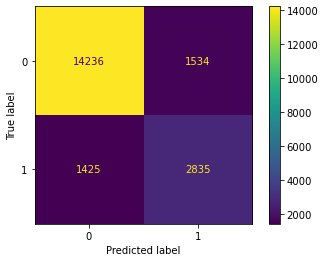

In [112]:
plot_confusion_matrix(knn_pipe, X_train, y_train)

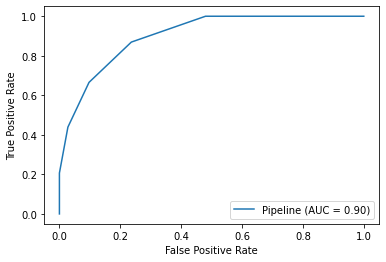

In [113]:
plot_roc_curve(knn_pipe, X_train, y_train)

In [114]:
preds = knn_pipe.predict(X_train)

f1_score(y_train, preds)

0.6570865685479198

###### Decision Tree model

In [115]:
# dt_pipe = ImPipeline(steps = [
#     ('ct', ct),
#     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#     ('dt', DecisionTreeClassifier(random_state=1))
# ]).fit(X_train,y_train)

**Change the ('ct',ct) to simple imputer with some strategy for dt_pipe?**

In [116]:
# dt_pickle = 'dt_pipe.sav'
# pickle.dump(dt_pipe, open(dt_pickle, 'wb'))

In [117]:
dt_pipe = pickle.load(open('dt_pipe.sav', 'rb'))

In [ ]:
# ModelWithCV(dt_pipe,'dt',X_train,y_train).cv_mean #0.7581627558662006

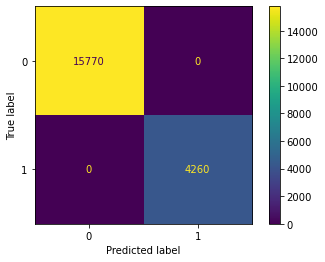

In [118]:
plot_confusion_matrix(dt_pipe, X_train, y_train)

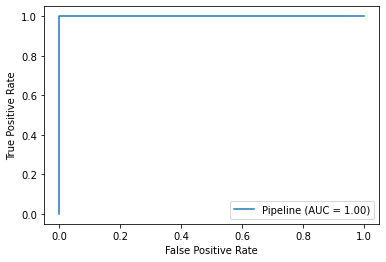

In [119]:
plot_roc_curve(dt_pipe, X_train, y_train)

In [120]:
preds = dt_pipe.predict(X_train)

f1_score(y_train, preds)

1.0

###### SVC model

In [122]:
# svm_pipe = ImPipeline(steps = [
#     ('ct', ct),
#     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#     ('svm', SVC(random_state=1))
# ]).fit(X_train,y_train)

In [123]:
# svm_pickle = 'svm_pipe.sav'
# pickle.dump(svm_pipe, open(svm_pickle, 'wb'))

In [124]:
svm_pipe = pickle.load(open('svm_pipe.sav', 'rb'))

In [125]:
#takes a long time to load
#cv_svm = ModelWithCV(svm_pipe,'svm',X_train,y_train).cv_mean

In [126]:
#cv_svm = 0.8356465302046929

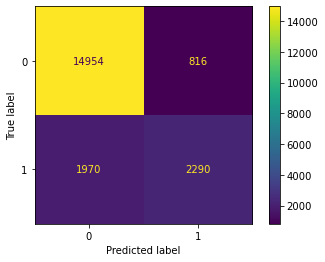

In [127]:
plot_confusion_matrix(svm_pipe, X_train, y_train)

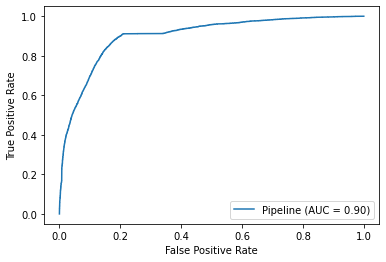

In [128]:
plot_roc_curve(svm_pipe, X_train, y_train)

In [129]:
preds = svm_pipe.predict(X_train)

f1_score(y_train, preds)

0.6217757263100733

##### voting model

In [130]:
#found the parameters for the logistic regression so we'll input this in our voting classifer
# logreg2_pipe = ImPipeline(steps = [
#     ('ct', ct),
#     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#     ('logreg', LogisticRegression(random_state=1,C=1, max_iter=50, penalty = 'l1', solver='saga' ))
# ]).fit(X_train,y_train)

In [131]:
# voting_complex = VotingClassifier(estimators= [
#     ('lr', logreg2_pipe),
#     ('sv1', svm_pipe),
#     ('knn', knn_pipe),
#     ('dt', dt_pipe)
# ], n_jobs=-1).fit(X_train,y_train)

In [132]:
# voting_pickle = 'voting.sav'
# pickle.dump(voting_complex, open(voting_pickle, 'wb'))

In [133]:
voting_complex = pickle.load(open('log_grid_search.sav', 'rb'))

In [134]:
#ModelWithCV(voting_complex, 'voting', X_train, y_train).cv_mean # 0.834648027958063

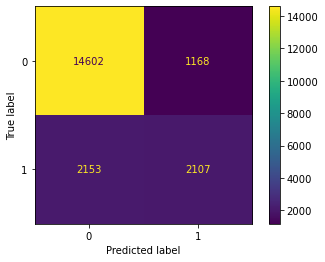

In [135]:
plot_confusion_matrix(voting_complex, X_train, y_train)

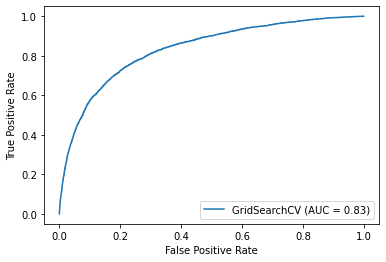

In [136]:
plot_roc_curve(voting_complex, X_train, y_train)

In [137]:
preds = voting_complex.predict(X_train)

f1_score(y_train, preds)

0.5592568015925681

##### let's try out random forest instead 

In [138]:
#bagging- no need to pickle as it doesn't take too long to run
bagdt_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('bag', BaggingClassifier(random_state= 1))
]).fit(X_train, y_train)

In [139]:
ModelWithCV(bagdt_pipe, 'bagging', X_train, y_train).cv_mean

0.8195706440339491

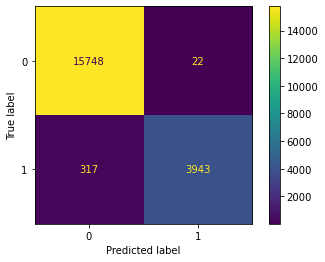

In [140]:
plot_confusion_matrix(bagdt_pipe, X_train, y_train)

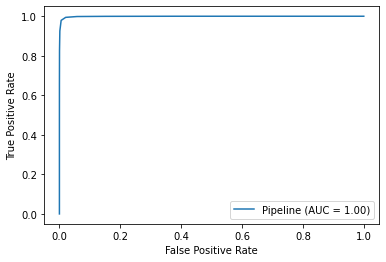

In [141]:
plot_roc_curve(bagdt_pipe, X_train, y_train)

In [142]:
preds = bagdt_pipe.predict(X_train)

f1_score(y_train, preds)

0.9587841945288754

Better than the decision tree by itself.

#### Final Model

In [143]:
#fit it with the entire train df

### Testing set

#### Any sort of transformation done on training do on testing

In [144]:
##SS/OHE

#### Evaluation of the testing set on our final model and comparison of error